In [1]:
import torch
import feature_groups
import pickle
import argparse
import numpy as np
import torch.nn as nn
from torchmetrics import AUROC,Accuracy
from torch.utils.data import DataLoader, random_split
import os
from os import path
from dime.data_utils import DenseDatasetSelected, get_group_matrix, get_xy, data_split
from dime.utils import MaskLayerGrouped
from dime import MaskingPretrainer, CMIEstimator
from pytorch_lightning import Trainer
import matplotlib.pyplot as plt
import pandas as pd
import pickle

# Load Dataset

In [2]:
auc_metric = AUROC(task='multiclass', num_classes=2)
acc_metric = Accuracy(task='multiclass', num_classes=2)
intub_feature_names = feature_groups.intub_feature_names
intub_feature_groups = feature_groups.intub_feature_groups
device = torch.device('cuda', 1)

cols_to_drop = []
if cols_to_drop is not None:
    intub_feature_names = [item for item in intub_feature_names if str(intub_feature_names.index(item)) not in cols_to_drop]

# Load dataset
dataset = DenseDatasetSelected('data/intub.csv', cols_to_drop=cols_to_drop)
d_in = dataset.X.shape[1]  # 121
d_out = len(np.unique(dataset.Y))  # 2
feature_groups_dict, feature_groups_mask = get_group_matrix(intub_feature_names, intub_feature_groups)
num_groups = len(feature_groups_mask) 
train_dataset, val_dataset, test_dataset = random_split(dataset, [0.8, 0.1, 0.1], generator=torch.Generator().manual_seed(0))
# Find mean/variance for normalizing
x, y = get_xy(train_dataset)
mean = np.mean(x, axis=0)
std = np.std(y, axis=0)

# Normalize via the original dataset
dataset.X = dataset.X - mean


Index(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9',
       ...
       '103', '104', '105', '106', '107', '108', '109', '110', '111',
       'Outcome'],
      dtype='object', length=113)


# Set up networks

In [3]:
# Set up architecture
hidden = 128
dropout = 0.3
d_in = dataset.X.shape[1]  # 121
d_out = len(np.unique(dataset.Y))  # 2
print(d_out)
# Outcome Predictor
predictor = nn.Sequential(
    nn.Linear(d_in + num_groups, hidden),
    nn.ReLU(),
    nn.Dropout(dropout),
    nn.Linear(hidden, hidden),
    nn.ReLU(),
    nn.Dropout(dropout),
    nn.Linear(hidden, d_out)).to(device)

# CMI Predictor
value_network = nn.Sequential(
    nn.Linear(d_in + num_groups, hidden),
    nn.ReLU(),
    nn.Dropout(dropout),
    nn.Linear(hidden, hidden),
    nn.ReLU(),
    nn.Dropout(dropout),
    nn.Linear(hidden, num_groups)).to(device)

test_dataloader = DataLoader(
        test_dataset, batch_size=128, shuffle=False, pin_memory=True, num_workers=4)

val_dataloader = DataLoader(
        val_dataset, batch_size=128, shuffle=False, pin_memory=True, num_workers=4)


mask_layer = MaskLayerGrouped(append=True, group_matrix=torch.tensor(feature_groups_mask))

trainer = Trainer(
                    accelerator='gpu',
                    devices=[device.index],
                    precision=16
                )

2


Using 16bit None Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


# Evaluate Penalized Policy

In [ ]:
for trial in range(5):
    results_dict = {"acc": {}}
    trained_model_path = f"<path_to_trained_model>"
    greedy_cmi_estimator = CMIEstimator.load_from_checkpoint(trained_model_path,
                                                             value_network=value_network,
                                                             predictor=predictor,
                                                             mask_layer=mask_layer,
                                                             lr=1e-3,
                                                             max_features=30,
                                                             eps=0.1,
                                                             loss_fn=nn.CrossEntropyLoss(reduction='none'),
                                                             val_loss_fn=auc_metric,
                                                             eps_decay=0.2,
                                                             eps_steps=10,
                                                             patience=5,
                                                             feature_costs=None
                                                            ).to(device)
    avg_num_features_lambda = []
    accuracy_scores_lambda = []
    all_masks_lambda=[]
    # Evaluation Mode lambda penalty
    lamda_values = [0.000001, 0.00001, 0.00007, 0.0003, 0.0005] + [0.0012, 0.016] 

    for lamda in lamda_values:
        metric_dict = greedy_cmi_estimator.inference(trainer, test_dataloader,feature_costs=None, lam=lamda)
    
        y = metric_dict['y']
        pred = metric_dict['pred']
        auc_score = acc_metric(pred, y)
        final_masks = np.array(metric_dict['mask'])
        accuracy_scores_lamda.append(auc_score)
        avg_num_features_lamda.append(np.mean(np.sum(final_masks, axis=1)))
        results_dict['acc'][np.mean(np.sum(final_masks, axis=1))] = accuracy_score

        print(f"Lambda={lamda}, AUROC={accuracy_score}, Avg. num features={np.mean(np.sum(final_masks, axis=1))}")
        all_masks_lamda.append(final_masks)
    
    with open(f'results/intub_lamda_ours_trial_{trial}.pkl', 'wb') as f:
        pickle.dump(results_dict, f)


# Evaluate with Budget Constrained Policy

In [4]:
import sklearn.metrics as metrics
num_selections = []
feature_index = []
freq = []

for trial in range(1):
    results_dict = {"acc": {}}
#     trained_model_path = f"/projects/leelab/sgadgil/Projects/DIME/experiments/intub/logs/max_features_40_with_decay_rate_0.2_use_entropy_false_feature_cost_False_trial_6/version_0/checkpoints/best_val_perfomance_model.ckpt"
    trained_model_path = f"/projects/leelab/sgadgil/Projects/DIME/experiments/intub/logs/max_features_40_with_decay_rate_0.2_use_entropy_feature_cost_False_trial_0/version_0/checkpoints/best_val_perfomance_model.ckpt"
    greedy_cmi_estimator = CMIEstimator.load_from_checkpoint(trained_model_path,
                                                                     value_network=value_network,
                                                                     predictor=predictor,
                                                                     mask_layer=mask_layer,
                                                                     lr=1e-3,
                                                                    max_features=40,
                                                                    eps=0.1,
                                                                    loss_fn=nn.CrossEntropyLoss(reduction='none'),
                                                                    val_loss_fn=auc_metric,
                                                                    eps_decay=0.2,
                                                                    eps_steps=10,
                                                                    patience=5,
                                                                    feature_costs=None,
                                                             cmi_scaling='bounded'
                                                            ).to(device)
    avg_num_features_budget = []
    accuracy_scores_budget = []
    all_masks_budget=[]
    max_budget_values = range(1, 16) #[1, 3, 5, 10, 15, 20, 25]
    freq.append([0] * 36)
    for budget in max_budget_values:
        metric_dict_budget = greedy_cmi_estimator.inference(trainer, test_dataloader, feature_costs=None, budget=budget)
        
        y = metric_dict_budget['y']
        pred = metric_dict_budget['pred']
        conf_matrix = metrics.confusion_matrix(y, np.argmax(pred, axis=1))
        cls_acc = np.diag(conf_matrix) / np.sum(conf_matrix, 1) # accuracy per class
        cls_avg = np.sum(cls_acc) / conf_matrix.shape[0]
        print("Rebalanced accuracy: {}".format(cls_avg))

        accuracy_score = acc_metric(pred.float(), y)
        final_masks = np.array(metric_dict_budget['mask'])
        accuracy_scores_budget.append(accuracy_score)
        avg_num_features_budget.append(np.mean(np.sum(final_masks, axis=1)))
        results_dict['acc'][np.mean(np.sum(final_masks, axis=1))] = accuracy_score
        print(f"Budget={budget}, AUROC={accuracy_score}, Avg. num features={np.mean(np.sum(final_masks, axis=1))}")
#         num_selections += [budget] * final_masks.shape[1]
#         feature_index += list(range(0, final_masks.shape[1]))
        freq.append(list(sum(final_masks) / final_masks.shape[0]))
        all_masks_budget.append(final_masks)
    
    with open(f'results/intub_ours_trial_{trial}_auc.pkl', 'wb') as f:
        pickle.dump(results_dict, f)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting DataLoader 0: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 52/52 [00:01<00:00, 44.96it/s]
Rebalanced accuracy: 0.6188901516607279


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Budget=1, AUROC=0.8760494589805603, Avg. num features=1.0
Predicting DataLoader 0: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 52/52 [00:00<00:00, 72.70it/s]
Rebalanced accuracy: 0.6327124705124474
Budget=2, AUROC=0.8795603513717651, Avg. num features=2.0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting DataLoader 0: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 52/52 [00:00<00:00, 58.15it/s]
Rebalanced accuracy: 0.6488139095233127


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Budget=3, AUROC=0.8833765983581543, Avg. num features=3.0
Predicting DataLoader 0: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 52/52 [00:01<00:00, 46.88it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Rebalanced accuracy: 0.6580201567667184
Budget=4, AUROC=0.8847504258155823, Avg. num features=4.0
Predicting DataLoader 0: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 52/52 [00:01<00:00, 40.86it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Rebalanced accuracy: 0.6599691261435863
Budget=5, AUROC=0.8852083683013916, Avg. num features=5.0
Predicting DataLoader 0: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 52/52 [00:01<00:00, 35.23it/s]
Rebalanced accuracy: 0.6530709147043375
Budget=6, AUROC=0.884903073310852, Avg. num features=6.0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting DataLoader 0: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 52/52 [00:01<00:00, 30.96it/s]
Rebalanced accuracy: 0.6555904190389391
Budget=7, AUROC=0.884903073310852, Avg. num features=7.0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting DataLoader 0: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 52/52 [00:02<00:00, 24.36it/s]
Rebalanced accuracy: 0.6713038759775044
Budget=8, AUROC=0.8873454332351685, Avg. num features=8.0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting DataLoader 0: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 52/52 [00:03<00:00, 16.95it/s]
Rebalanced accuracy: 0.6704062099092818
Budget=9, AUROC=0.8858189582824707, Avg. num features=9.0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting DataLoader 0: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 52/52 [00:03<00:00, 15.45it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]



Rebalanced accuracy: 0.6736149314534504
Budget=10, AUROC=0.88627690076828, Avg. num features=10.0
Predicting DataLoader 0: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 52/52 [00:03<00:00, 14.03it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]



Rebalanced accuracy: 0.6788015380194979
Budget=11, AUROC=0.8879560232162476, Avg. num features=11.0
Predicting DataLoader 0: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 52/52 [00:03<00:00, 13.09it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]



Rebalanced accuracy: 0.6762531180398853
Budget=12, AUROC=0.8871927857398987, Avg. num features=12.0
Predicting DataLoader 0: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 52/52 [00:04<00:00, 12.29it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]



Rebalanced accuracy: 0.6746342994452954
Budget=13, AUROC=0.8865821957588196, Avg. num features=13.0
Predicting DataLoader 0: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 52/52 [00:04<00:00, 11.30it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Rebalanced accuracy: 0.6722045617175161
Budget=14, AUROC=0.8867348432540894, Avg. num features=14.0
Predicting DataLoader 0: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 52/52 [00:04<00:00, 11.20it/s]
Rebalanced accuracy: 0.6714544935461378
Budget=15, AUROC=0.8868874907493591, Avg. num features=15.0


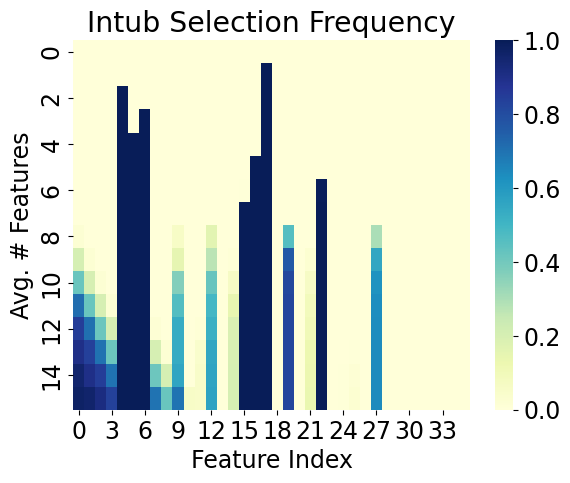

In [6]:
import seaborn as sns
df = pd.DataFrame(np.array(freq))
plt.rcParams.update({'font.size': 17})
sns.heatmap(df,  cmap="YlGnBu")
plt.xlabel("Feature Index")
plt.ylabel("Avg. # Features")
plt.title("Intub Selection Frequency")
plt.savefig("Intub_Selection_Freq.pdf", format="pdf", bbox_inches="tight")

In [19]:
np.sum(final_masks, axis=0)

array([2760., 1329.,  128.,    0., 6551., 6551., 6551.,    0.,    0.,
       2429.,    0.,    0., 2765.,    0.,  417., 6551., 6551., 6551.,
          0., 5340.,    0.,  434., 6551.,    0.,    0.,    0.,    0.,
       4051.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.],
      dtype=float32)

In [5]:
import sklearn.metrics as metrics
feature_costs = [1, 1, 3, 3, 3, 3, 4, 4, 5, 4, 4, 6, 6, 6, 6, 7, 7, 7, 2, 8, 8, 9, 8, 7, 7, 7, 8, 10, 9, 7, 10, 10, 10, 10, 6, 8]
freq = []
for trial in range(1):
    results_dict = {"acc": {}}
    trained_model_path = f"/projects/leelab/sgadgil/Projects/DIME/experiments/intub/logs/max_features_40_with_decay_rate_0.2_use_entropy_feature_cost_True_trial_0/version_4/checkpoints/best_val_perfomance_model.ckpt"
    greedy_cmi_estimator = CMIEstimator.load_from_checkpoint(trained_model_path,
                                                                     value_network=value_network,
                                                                     predictor=predictor,
                                                                     mask_layer=mask_layer,
                                                                     lr=1e-3,
                                                                    max_features=40,
                                                                    eps=0.1,
                                                                    loss_fn=nn.CrossEntropyLoss(reduction='none'),
                                                                    val_loss_fn=auc_metric,
                                                                    eps_decay=0.2,
                                                                    eps_steps=10,
                                                                    patience=5,
                                                                    feature_costs=np.array(feature_costs)
                                                            ).to(device)
    avg_num_features_budget = []
    accuracy_scores_budget = []
    all_masks_budget=[]
    max_budget_values = range(1, 15)#[1, 3, 5, 10, 15, 20, 25, 30]
    for budget in max_budget_values:
        metric_dict_budget = greedy_cmi_estimator.inference(trainer, test_dataloader, feature_costs=np.array(feature_costs), budget=budget)
        
        y = metric_dict_budget['y']
        pred = metric_dict_budget['pred']
        conf_matrix = metrics.confusion_matrix(y, np.argmax(pred, axis=1))
        cls_acc = np.diag(conf_matrix) / np.sum(conf_matrix, 1) # accuracy per class
        cls_avg = np.sum(cls_acc) / conf_matrix.shape[0]
        print("Rebalanced accuracy: {}".format(cls_avg))

        accuracy_score = acc_metric(pred.float(), y)
        final_masks = np.array(metric_dict_budget['mask'])
        accuracy_scores_budget.append(accuracy_score)
        avg_num_features_budget.append(np.mean(np.sum(final_masks, axis=1)))
        results_dict['acc'][np.mean(np.sum(final_masks, axis=1))] = accuracy_score
        print(f"Budget={budget}, AUROC={accuracy_score}, Avg. num features={np.mean(np.sum(final_masks * feature_costs, axis=1))}")
        freq.append(list(sum(final_masks) / final_masks.shape[0]))

        all_masks_budget.append(final_masks)
    
    with open(f'results/intub_ours_trial_{trial}_auc.pkl', 'wb') as f:
        pickle.dump(results_dict, f)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting DataLoader 0:  73%|████████████████████████████████████████████████████████████████▎                       | 38/52 [00:07<00:02,  4.78it/s]
Predicting: 52it [00:00, 61.59it/s]
Rebalanced accuracy: 0.5
Budget=1, AUROC=0.8502518534660339, Avg. num features=3.0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting DataLoader 0: 100%|████████████████████████████████████████████████████████████████████████████████████████| 52/52 [00:00<00:00, 54.34it/s]
Rebalanced accuracy: 0.6299525820023901


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Budget=2, AUROC=0.8798656463623047, Avg. num features=10.0
Predicting DataLoader 0: 100%|████████████████████████████████████████████████████████████████████████████████████████| 52/52 [00:01<00:00, 39.67it/s]
Rebalanced accuracy: 0.6303116484296791
Budget=3, AUROC=0.8804762363433838, Avg. num features=17.0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting DataLoader 0: 100%|████████████████████████████████████████████████████████████████████████████████████████| 52/52 [00:01<00:00, 32.55it/s]
Rebalanced accuracy: 0.627612610881433
Budget=4, AUROC=0.8801709413528442, Avg. num features=24.0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting DataLoader 0: 100%|████████████████████████████████████████████████████████████████████████████████████████| 52/52 [00:01<00:00, 27.64it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]



Rebalanced accuracy: 0.6267727761032325
Budget=5, AUROC=0.8801709413528442, Avg. num features=33.74263471225767
Predicting DataLoader 0: 100%|████████████████████████████████████████████████████████████████████████████████████████| 52/52 [00:02<00:00, 23.61it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]



Rebalanced accuracy: 0.6251539575086427
Budget=6, AUROC=0.8795603513717651, Avg. num features=36.355823538391085
Predicting DataLoader 0: 100%|████████████████████████████████████████████████████████████████████████████████████████| 52/52 [00:02<00:00, 21.21it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]



Rebalanced accuracy: 0.6326196842338361
Budget=7, AUROC=0.881544828414917, Avg. num features=39.128987940772404
Predicting DataLoader 0: 100%|████████████████████████████████████████████████████████████████████████████████████████| 52/52 [00:02<00:00, 18.60it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]



Rebalanced accuracy: 0.6371170735903166
Budget=8, AUROC=0.8827660083770752, Avg. num features=42.35460235078614
Predicting DataLoader 0: 100%|████████████████████████████████████████████████████████████████████████████████████████| 52/52 [00:03<00:00, 16.85it/s]
Rebalanced accuracy: 0.635889256739816
Budget=9, AUROC=0.8813921809196472, Avg. num features=45.34895435811327


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting DataLoader 0: 100%|████████████████████████████████████████████████████████████████████████████████████████| 52/52 [00:03<00:00, 15.71it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]



Rebalanced accuracy: 0.641226480874497
Budget=10, AUROC=0.8826133608818054, Avg. num features=48.19966417340864
Predicting DataLoader 0: 100%|████████████████████████████████████████████████████████████████████████████████████████| 52/52 [00:03<00:00, 14.20it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]



Rebalanced accuracy: 0.642216933221331
Budget=11, AUROC=0.8821554183959961, Avg. num features=51.655625095405284
Predicting DataLoader 0: 100%|████████████████████████████████████████████████████████████████████████████████████████| 52/52 [00:03<00:00, 13.27it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]



Rebalanced accuracy: 0.6482753098823792
Budget=12, AUROC=0.8824607133865356, Avg. num features=55.376736376125784
Predicting DataLoader 0: 100%|████████████████████████████████████████████████████████████████████████████████████████| 52/52 [00:04<00:00, 12.12it/s]
Rebalanced accuracy: 0.6564043578439177
Budget=13, AUROC=0.8820027709007263, Avg. num features=59.77698061364677


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting DataLoader 0: 100%|████████████████████████████████████████████████████████████████████████████████████████| 52/52 [00:04<00:00, 11.44it/s]
Rebalanced accuracy: 0.6612060020094543
Budget=14, AUROC=0.8801709413528442, Avg. num features=63.73439169592429


<Axes: >

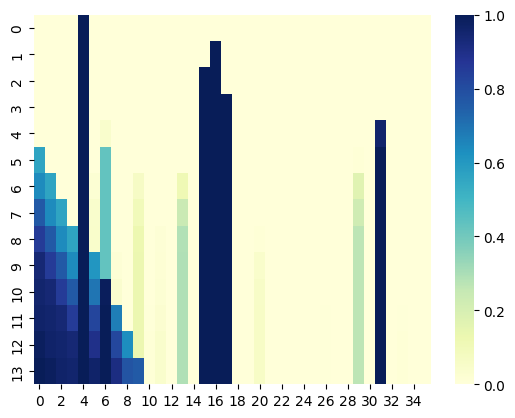

In [7]:
import seaborn as sns
df = pd.DataFrame(np.array(freq))
sns.heatmap(df,  cmap="YlGnBu")